In [35]:
import sys
sys.path.insert(0,"/home/albert7a/lib/python")


## imports

import numpy as np
import dask
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import glob as glob
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap
import time
from dask.diagnostics import ProgressBar
from datetime import date
import yaml
import io
import json
import cmocean
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

%matplotlib inline

In [7]:
def select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax):
        ''' Identify all the EN4 profiles that fall within the selected zone and period
        '''
        ## Datasets

        #EN4
        diren4="/media/extra/DATA/EN4/"

        yearmin=datemin[0:4]
        monthmin=datemin[5:7]
        yearmax=datemax[0:4]
        monthmax=datemax[5:7]

        list_filesEN4=[]
        if yearmin == yearmax:
            for m in np.arange(int(monthmin),int(monthmax)+1):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+str(m)+'.nc')
        else:
            for m in np.arange(int(monthmin),13):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmin+str(m)+'.nc')
            for m in np.arange(1,int(monthmax)+1):
                if m < 10:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmax+'0'+str(m)+'.nc')
                else:
                    list_filesEN4.append('EN.4.2.0.f.profiles.g10.'+yearmax+str(m)+'.nc')

        datetmin=pd.to_datetime(datemin)
        datetmax=pd.to_datetime(datemax)
        ttmin=datetime.datetime(int(datetmin.strftime('%Y')),int(datetmin.strftime('%m')),int(datetmin.strftime('%d')),int(datetmin.strftime('%H')),int(datetmin.strftime('%M')))
        ttmax=datetime.datetime(int(datetmax.strftime('%Y')),int(datetmax.strftime('%m')),int(datetmax.strftime('%d')),int(datetmax.strftime('%H')),int(datetmax.strftime('%M')))
        tsecmin=(ttmin-datetime.datetime(1958,1,1,0,0)).total_seconds()
        tsecmax=(ttmax-datetime.datetime(1958,1,1,0,0)).total_seconds()
        nb_profiles=0.
        for f in np.arange(len(list_filesEN4)):
                fileEN4=list_filesEN4[f]
                tfileEN4=diren4+fileEN4

                dsen4=xr.open_dataset(tfileEN4)
                laten4=dsen4['LATITUDE']
                lonen4=dsen4['LONGITUDE']
                dayen4=dsen4['JULD']
                refen4=dsen4['DC_REFERENCE']

                indz=np.where((lonmin<lonen4.values)&(lonen4.values<lonmax)&(latmin<laten4.values)&(laten4.values<latmax))
                prof_zone=[]
                tsecen4z=[]
                nb_profiles=nb_profiles+len(indz[0])
        return nb_profiles


In [11]:
latmin,latmax,lonmin,lonmax = 27,60,-80,8
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'

%timeit nb_profiles_NATL60_1year=select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax)
print nb_profiles_NATL60_1year


1 loop, best of 3: 613 ms per loop
90549.0


In [28]:
#quadrillage tous les 0.5°

Xbox=(lonmax-lonmin+1)/0.5
Ybox=(latmax-latmin+1)/0.5

nb_prof_box05_1year=np.zeros((Xbox,Ybox,3))

for i in np.arange(Xbox):
    for j in np.arange(Ybox):
        lat1=latmin+0.5*j
        lat2=latmin+0.5*(j+1.)
        lon1=lonmin+0.5*i
        lon2=lonmin+0.5*(i+1.)
        nb=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
        nb_prof_box05_1year[i,j,0]=nb
        nb_prof_box05_1year[i,j,1]=0.5*(lat2+lat1)
        nb_prof_box05_1year[i,j,2]=0.5*(lon1+lon2)


/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


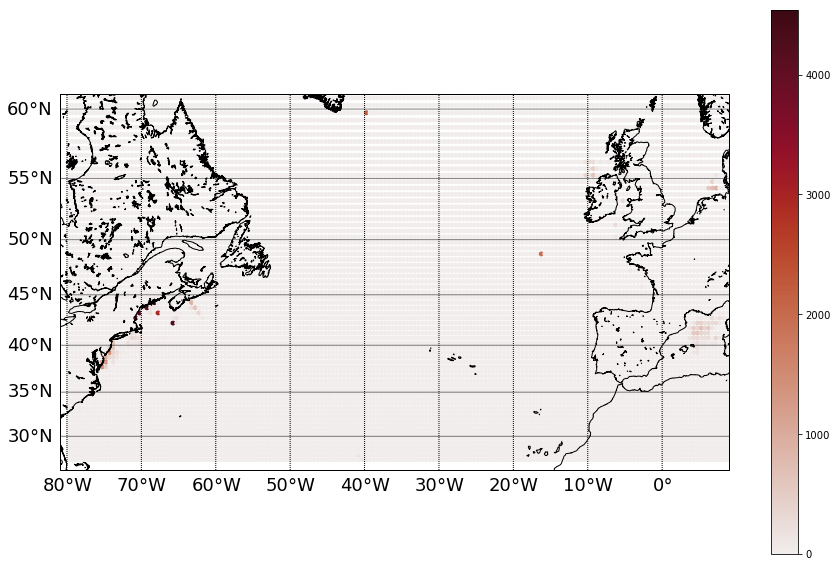

In [30]:
fig = plt.figure(figsize=(15,10))  # (w,h)

cm = plt.cm.get_cmap(cmocean.cm.amp)

my_map0 = Basemap(projection='merc', lat_0=(latmin+latmax)/2, lon_0=(lonmin+lonmax)/2, 
resolution = 'i', 
llcrnrlon = lonmin-1, llcrnrlat= latmin-1,
urcrnrlon = lonmax+1, urcrnrlat = latmax+1, area_thresh = 10)

my_map0.drawcoastlines() 
my_map0.drawmapboundary()
my_map0.drawmeridians(np.arange(-120, 60, 10), labels=[1,0,0,1], size=18);
my_map0.drawparallels(np.arange(0, 80, 5), labels=[1,0,0,1], size=18);
my_map0.scatter(nb_prof_box05_1year[:,:,2], nb_prof_box05_1year[:,:,1], c=nb_prof_box05_1year[:,:,0],latlon=True, linewidth='0', s=25, cmap=cm);
plt.colorbar();


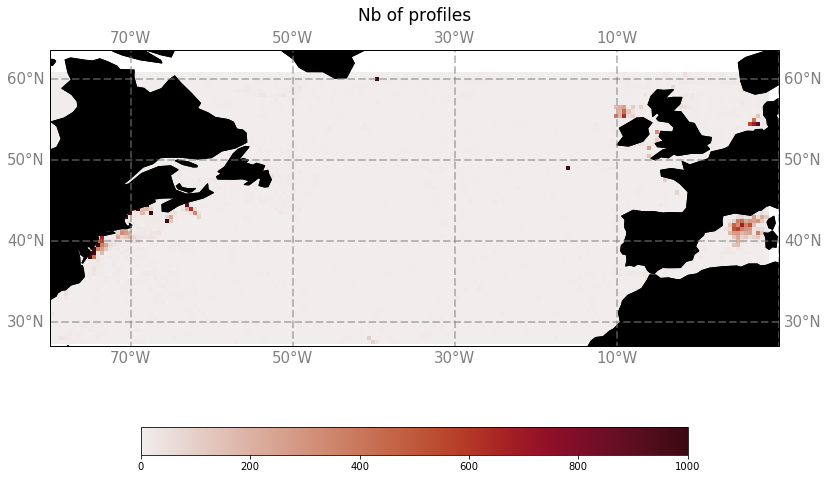

In [47]:
fig = plt.figure(figsize=(15,10))  # (w,h)
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=-30))
ax.set_extent([-80, 10, 27, 55])
pcolor=ax.pcolormesh(nb_prof_box05_1year[:,:,2], nb_prof_box05_1year[:,:,1],nb_prof_box05_1year[:,:,0],transform=ccrs.PlateCarree(),cmap=cmocean.cm.amp,vmin=0,vmax=1000)
ax.add_feature(cfeature.LAND,facecolor='black')
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=2, color='grey', alpha=0.5, linestyle='--')

fig.subplots_adjust(right=0.8)
gl.xlocator = mticker.FixedLocator([-110,-90,-70,-50,-30,-10,10,30,50,70,90,110])
gl.ylocator = mticker.FixedLocator([-10,0,10,20,30,40,50,60,70,80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.ylabel_style = {'size': 15, 'color': 'gray'}
cbar = plt.colorbar(pcolor,orientation='horizontal',shrink=0.75)

ax.set_title('Nb of profiles',size=17,y=1.08)


In [39]:
np.nanmax(nb_prof_box05_1year[:,:,0])

4538.0

In [40]:
print nb_prof_box05_1year[:,:,0]


[[  2.   0.   0. ...,   0.   0.   0.]
 [  9.  12.   0. ...,   0.   0.   0.]
 [  2.  33.   1. ...,   0.   0.   0.]
 ..., 
 [  0.   0.   0. ...,   0.   0.   0.]
 [  0.   0.   0. ...,   0.   0.   0.]
 [  0.   0.   0. ...,   0.   0.   0.]]


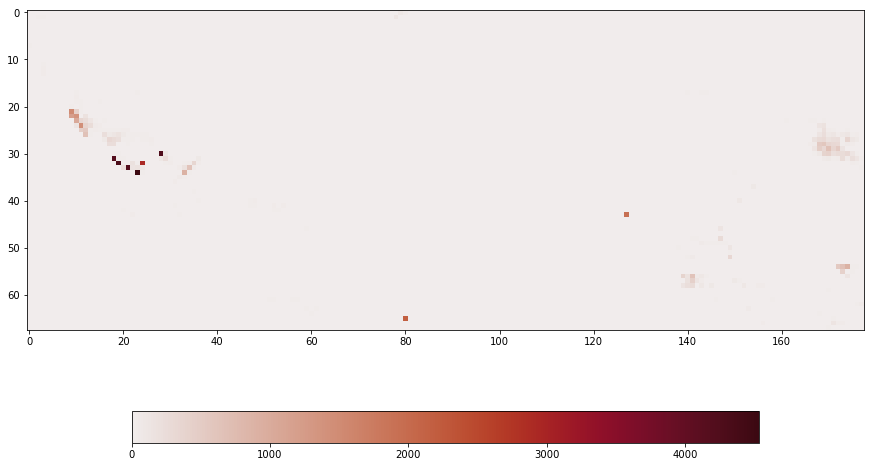

In [45]:
fig = plt.figure(figsize=(15,10))  # (w,h)
pcolor=plt.imshow(nb_prof_box05_1year[:,:,0].T,cmap=cmocean.cm.amp)
plt.colorbar(pcolor,orientation='horizontal',shrink=0.75)


In [48]:
#quadrillage tous les 0.5°

Xbox=(lonmax-lonmin+1)/0.25
Ybox=(latmax-latmin+1)/0.25

nb_prof_box05_1year=np.zeros((Xbox,Ybox,3))

for i in np.arange(Xbox):
    for j in np.arange(Ybox):
        lat1=latmin+0.25*j
        lat2=latmin+0.25*(j+1.)
        lon1=lonmin+0.25*i
        lon2=lonmin+0.25*(i+1.)
        nb=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
        nb_prof_box05_1year[i,j,0]=nb
        nb_prof_box05_1year[i,j,1]=0.5*(lat2+lat1)
        nb_prof_box05_1year[i,j,2]=0.5*(lon1+lon2)


/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [91]:
nb_prof_box05_1year.shape

(356, 136, 3)

In [51]:
np.nanmax(nb_prof_box05_1year[:,:,0])

4448.0

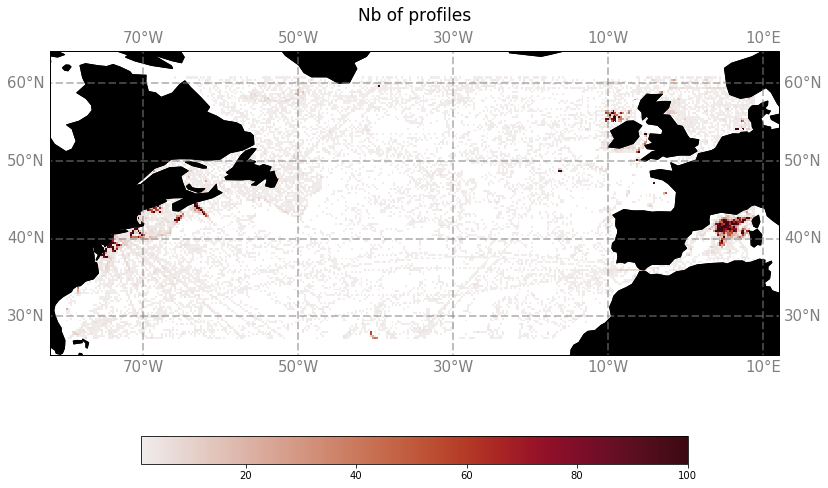

In [69]:
fig = plt.figure(figsize=(15,10))  # (w,h)
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=-30))
ax.set_extent([-82, 12, 25, 55])
cmap=cmocean.cm.amp
cmap.set_under(color='white')
pcolor=ax.pcolormesh(nb_prof_box05_1year[:,:,2], nb_prof_box05_1year[:,:,1],nb_prof_box05_1year[:,:,0],transform=ccrs.PlateCarree(),cmap=cmap,vmin=1,vmax=100)
ax.add_feature(cfeature.LAND,facecolor='black')
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=2, color='grey', alpha=0.5, linestyle='--')

fig.subplots_adjust(right=0.8)
gl.xlocator = mticker.FixedLocator([-110,-90,-70,-50,-30,-10,10,30,50,70,90,110])
gl.ylocator = mticker.FixedLocator([-10,0,10,20,30,40,50,60,70,80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.ylabel_style = {'size': 15, 'color': 'gray'}
cbar = plt.colorbar(pcolor,orientation='horizontal',shrink=0.75)

ax.set_title('Nb of profiles',size=17,y=1.08)
plt.savefig("nb_profiles_decoupage025.png")

In [63]:
idgrand=np.where(nb_prof_box05_1year[:,:,0]>500)

In [65]:
idgrand[0].shape

(18,)

In [66]:
idgrand[1].shape

(18,)

In [64]:
nb_prof_box05_1year[idgrand[0][:],idgrand[1][:],0]

array([ 1202.,   938.,  1325.,   767.,   534.,   585.,  4183.,  4285.,
        4089.,  4448.,  2927.,  4107.,  2168.,   641.,  1180.,   542.,
         679.,   881.])

In [70]:
nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],0]

1202.0

In [71]:
nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]

37.875

In [72]:
nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]

-75.125

In [73]:
lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.125
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.125
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]+0.125
nb_profiles_big1=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)

In [74]:
nb_profiles_big1

1202.0

In [75]:
lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.125
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]
nb_profiles_big11=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big11

lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.125
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]+0.125
nb_profiles_big12=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big12

lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.125
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]
nb_profiles_big13=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big13

lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.125
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]+0.125
nb_profiles_big14=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big14



745.0
96.0
359.0
2.0


In [76]:
lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.125
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]
nb_profiles_big11=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big11

lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.125
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.125
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]+0.125
nb_profiles_big12=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big12

lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.125
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]
nb_profiles_big13=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big13




745.0
98.0
359.0


In [82]:
lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.125
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.125
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]+0.125
nb_profiles_big11=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big11

lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.125
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.0625
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.0625
nb_profiles_big121=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big121

lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.0625
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.0625
nb_profiles_big122=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big122

lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.125
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.0625
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.0625
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]
nb_profiles_big123=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big123

lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.0625
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.0625
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]
nb_profiles_big124=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big124

lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.0625
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.0625
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]
nb_profiles_big131=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big131

lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.0625
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.0625
nb_profiles_big132=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big132

lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.0625
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.125
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.0625
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]
nb_profiles_big133=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big133

lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.0625
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.125
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.0625
nb_profiles_big134=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big134


98.0
140.0
482.0
93.0
30.0
14.0
177.0
73.0
95.0


In [83]:
lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.125
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.0625
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.0625
nb_profiles_big1211=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big1211


140.0


In [84]:
lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.0625
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.0625
nb_profiles_big122=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big122


482.0


In [85]:
lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.0625
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.0625
nb_profiles_big132=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big132


177.0


In [86]:
lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.125
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.125
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]+0.125
datemin,datemax = '2012-10-01T00:01','2013-09-30T23:59'
nb_profiles_big1=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big1

1202.0


In [88]:
lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.125
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.125
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]+0.125
datemin,datemax = '2012-10-01T00:01','2013-03-31T23:59'
nb_profiles_big11=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big11
lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.125
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.125
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]+0.125
datemin,datemax = '2013-04-01T00:01','2013-09-30T23:59'
nb_profiles_big12=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big12

4.0
1198.0


In [89]:
lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.125
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.125
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]+0.125
datemin,datemax = '2012-10-01T00:01','2012-10-31T23:59'
nb_profiles_big11=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big11
lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.125
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.125
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]+0.125
datemin,datemax = '2012-11-01T00:01','2012-11-30T23:59'
nb_profiles_big12=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big12
lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.125
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.125
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]+0.125
datemin,datemax = '2012-12-01T00:01','2012-12-31T23:59'
nb_profiles_big13=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big13
lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.125
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.125
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]+0.125
datemin,datemax = '2013-01-01T00:01','2013-01-31T23:59'
nb_profiles_big14=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big14
lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.125
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.125
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]+0.125
datemin,datemax = '2013-02-01T00:01','2013-02-28T23:59'
nb_profiles_big15=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big15
lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.125
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.125
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]+0.125
datemin,datemax = '2013-03-01T00:01','2013-03-31T23:59'
nb_profiles_big16=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big16
lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.125
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.125
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]+0.125
datemin,datemax = '2013-04-01T00:01','2013-04-30T23:59'
nb_profiles_big17=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big17
lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.125
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.125
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]+0.125
datemin,datemax = '2013-05-01T00:01','2013-05-31T23:59'
nb_profiles_big18=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big18
lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.125
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.125
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]+0.125
datemin,datemax = '2013-06-01T00:01','2013-06-30T23:59'
nb_profiles_big19=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big19
lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.125
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.125
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]+0.125
datemin,datemax = '2013-07-01T00:01','2013-07-31T23:59'
nb_profiles_big110=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big110
lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.125
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.125
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]+0.125
datemin,datemax = '2013-08-01T00:01','2013-08-31T23:59'
nb_profiles_big111=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big111
lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.125
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.125
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]+0.125
datemin,datemax = '2013-09-01T00:01','2013-09-30T23:59'
nb_profiles_big112=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big112


0.0
1.0
0.0
0.0
0.0
3.0
0.0
0.0
0.0
0.0
0.0
1198.0


In [90]:
lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.125
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.125
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]+0.125
datemin,datemax = '2013-09-01T00:01','2013-09-10T23:59'
nb_profiles_big1121=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big1121
lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.125
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.125
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]+0.125
datemin,datemax = '2013-09-11T00:01','2013-09-20T23:59'
nb_profiles_big1122=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big1122
lat1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]-0.125
lat2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],1]+0.125
lon1=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]-0.125
lon2=nb_prof_box05_1year[idgrand[0][0],idgrand[1][0],2]+0.125
datemin,datemax = '2013-09-21T00:01','2013-09-30T23:59'
nb_profiles_big1123=select_profiles(lat1,lat2,lon1,lon2,datemin,datemax)
print nb_profiles_big1123


1198.0
1198.0
1198.0


In [92]:
    outname="/media/extra/DATA/EN4/EN4_nb_profiles_025grid.nc"
    print('output file is '+outname)
    dsout=Dataset(outname,'w')

    today=date.today()

    x=dsout.createDimension('x',356)
    y=dsout.createDimension('y',136)

    lat = dsout.createVariable('latitude', 'f8', ('y','x'))
    lat.standart_name="latitude"
    lat.long_name = "Latitude"
    lat.units = "degrees_north"

    lon = dsout.createVariable('longitude', 'f8', ('y','x'))
    lon.standart_name="longitude"
    lon.long_name = "Longitude"
    lon.units = "degrees_east"

    nb = dsout.createVariable('time_profileEN4', 'f8', ('y','x'))
    nb.standart_name="nb"
    nb.timeg_name = "Nb of EN4 profiles"
    nb.units = ""

   
    
    lat[:,:]=nb_prof_box05_1year[:,:,1]
    lon[:,:]=nb_prof_box05_1year[:,:,2]
    nb[:,:]=nb_prof_box05_1year[:,:,0]
    dsout.close()  # close the new file


output file is /media/extra/DATA/EN4/EN4_nb_profiles_025grid.nc


In [93]:
np.max(nb_prof_box05_1year[:,:,0])

4448.0